#Task 3

##Imports

In [1]:
from PIL import Image, ImageFilter, ImageOps
import numpy as np      # is ke ialwa ghar nahi chale ga
import matplotlib.pyplot as plt
import matplotlib
import cv2
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import copy          # deepcopy models for best chjkpnts
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.amp import autocast
from torch.utils.data import Subset, DataLoader, ConcatDataset     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict, OrderedDict

matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",   # safe default
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


##Dataset (CIFAR-100)

In [2]:
# -----------------------
# Transforms / datasets
# -----------------------
# Standard CIFAR-100 mean/std commonly used
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

data_root = "./data"

train_set = datasets.CIFAR100(root=data_root, train=True, download=True, transform=train_transform)
test_set  = datasets.CIFAR100(root=data_root, train=False, download=True, transform=test_transform)

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

100%|██████████| 169M/169M [00:07<00:00, 22.7MB/s]


Train set: 50000 images
Test set: 10000 images


##Model (VGG-16 Teacher and VGG-11 Student)

In [3]:
teacher_name = "cifar100_vgg16_bn"
student_pretrained_name = "cifar100_vgg11_bn"

teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", teacher_name, pretrained=True).to(device).eval()
student_pretrained = torch.hub.load("chenyaofo/pytorch-cifar-models", student_pretrained_name, pretrained=True).to(device).eval()

print("Loaded pretrained teacher:", teacher_name)
print("Loaded pretrained student (for comparison):", student_pretrained_name)

def evaluate(model, loader, device=device):
    model.eval()
    correct = 0
    total = 0
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    avg_loss = running_loss / total
    return avg_loss, acc

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt


100%|██████████| 58.4M/58.4M [00:00<00:00, 132MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg11_bn-57d0759e.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg11_bn-57d0759e.pt


100%|██████████| 37.4M/37.4M [00:00<00:00, 131MB/s]


Loaded pretrained teacher: cifar100_vgg16_bn
Loaded pretrained student (for comparison): cifar100_vgg11_bn


In [ ]:
t_loss, t_acc = evaluate(teacher, test_loader)
s_loss, s_acc = evaluate(student_pretrained, test_loader)
print(f"Teacher ({teacher_name}) test — loss: {t_loss:.4f}, acc: {t_acc:.2f}%")
print(f"Pretrained Student ({student_pretrained_name}) test — loss: {s_loss:.4f}, acc: {s_acc:.2f}%")

Teacher (cifar100_vgg16_bn) test — loss: 1.6428, acc: 74.00%
Pretrained Student (cifar100_vgg11_bn) test — loss: 1.4989, acc: 70.80%


In [4]:
def get_vgg11_untrained():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=False)
    return model.to(device)

def train_model(model, train_loader, test_loader,
                epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4, device=device):
    """
    Trains a CIFAR model from scratch, prints train+test accuracy each epoch,
    and returns lists of accuracies for plotting.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start = time.time()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        train_accs.append(train_acc)

        # Evaluate on test set after each epoch
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_acc = 100.0 * correct_test / total_test
        test_accs.append(test_acc)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch:02d}/{epochs} — "
              f"train_loss: {train_loss:.4f} — train_acc: {train_acc:.2f}% — "
              f"test_acc: {test_acc:.2f}% — time: {epoch_time:.1f}s")

    return model, train_accs, test_accs

In [ ]:
independent_student = get_vgg11_untrained()
print("Untrained student params:", sum(p.numel() for p in independent_student.parameters()))

independent_student, independent_student_train_accs, independent_student_test_accs = train_model(independent_student, train_loader, test_loader, epochs=50, lr=0.01)

# Evaluate trained from-scratch student on test set
test_loss, test_acc = evaluate(independent_student, test_loader)
print(f"Trained-from-scratch student final test — loss: {test_loss:.4f}, acc: {test_acc:.2f}%")

Untrained student params: 9802596


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch 01/50 — train_loss: 4.5434 — train_acc: 1.59% — test_acc: 2.98% — time: 21.5s
Epoch 02/50 — train_loss: 4.1421 — train_acc: 4.68% — test_acc: 6.14% — time: 22.5s
Epoch 03/50 — train_loss: 3.8238 — train_acc: 8.26% — test_acc: 12.89% — time: 20.8s
Epoch 04/50 — train_loss: 3.4942 — train_acc: 13.49% — test_acc: 16.87% — time: 21.7s
Epoch 05/50 — train_loss: 3.2321 — train_acc: 18.24% — test_acc: 24.12% — time: 22.2s
Epoch 06/50 — train_loss: 3.0267 — train_acc: 22.25% — test_acc: 25.33% — time: 21.7s
Epoch 07/50 — train_loss: 2.8643 — train_acc: 25.60% — test_acc: 28.65% — time: 21.8s
Epoch 08/50 — train_loss: 2.6933 — train_acc: 28.94% — test_acc: 34.21% — time: 21.5s
Epoch 09/50 — train_loss: 2.5500 — train_acc: 32.26% — test_acc: 35.85% — time: 21.5s
Epoch 10/50 — train_loss: 2.4190 — train_acc: 35.70% — test_acc: 37.95% — time: 20.8s
Epoch 11/50 — train_loss: 2.3095 — train_acc: 37.81% — test_acc: 41.69% — time: 21.6s
Epoch 12/50 — train_loss: 2.2143 — train_acc: 40.24% — test

##Logit Matching

In [5]:
def soft_cross_entropy(student_logits, teacher_logits, T=4.0):
    """KL-based soft loss for logit matching"""
    s_log_prob = F.log_softmax(student_logits / T, dim=1)
    t_prob = F.softmax(teacher_logits / T, dim=1)
    return F.kl_div(s_log_prob, t_prob, reduction='batchmean') * (T*T)


def smooth_labels(labels, num_classes, smoothing=0.1):
    """Convert hard labels to soft distributions"""
    with torch.no_grad():
        smooth = torch.full((labels.size(0), num_classes),
                            smoothing / (num_classes - 1)).to(labels.device)
        smooth.scatter_(1, labels.unsqueeze(1), 1.0 - smoothing)
    return smooth

In [6]:
def train_logit_matching(student, teacher, train_loader, test_loader,
                         epochs=50, lr=0.01, alpha=0.5, T=4.0, device=device):
    student = student.to(device)
    teacher.eval()
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        student.train()
        run_loss, correct, total = 0, 0, 0
        start = time.time()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(imgs)

            stu_logits = student(imgs)
            ce = criterion(stu_logits, labels)
            kd = soft_cross_entropy(stu_logits, teacher_logits, T)
            loss = (1 - alpha) * ce + alpha * kd

            opt.zero_grad()
            loss.backward()
            opt.step()

            run_loss += loss.item() * imgs.size(0)
            preds = stu_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        test_loss, test_acc = evaluate(student, test_loader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[LogitMatch] Epoch {epoch:02d}/{epochs} — loss: {run_loss/total:.4f} "
              f"— train_acc: {train_acc:.2f}% — test_acc: {test_acc:.2f}% — time: {time.time()-start:.1f}s")

    return student, train_accs, test_accs

def train_label_smoothing(student, train_loader, test_loader,
                          num_classes=100, epochs=50, lr=0.01, smoothing=0.1, device=device):
    student = student.to(device)
    opt = torch.optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        student.train()
        run_loss, correct, total = 0, 0, 0
        start = time.time()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            targets = smooth_labels(labels, num_classes, smoothing)

            logits = student(imgs)
            log_probs = F.log_softmax(logits, dim=1)
            loss = -(targets * log_probs).sum(dim=1).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            run_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        test_loss, test_acc = evaluate(student, test_loader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[LabelSmooth] Epoch {epoch:02d}/{epochs} — loss: {run_loss/total:.4f} "
              f"— train_acc: {train_acc:.2f}% — test_acc: {test_acc:.2f}% — time: {time.time()-start:.1f}s")

    return student, train_accs, test_accs

def dkd_loss(student_logits, teacher_logits, labels, alpha=1.0, beta=8.0, T=4.0):
    """Proper DKD implementation"""
    s_log_probs = F.log_softmax(student_logits / T, dim=1)
    t_probs = F.softmax(teacher_logits / T, dim=1)
    num_classes = student_logits.size(1)
    labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()

    # get target class probabilities
    s_target = (s_log_probs * labels_one_hot).sum(dim=1, keepdim=True)
    t_target = (t_probs * labels_one_hot).sum(dim=1, keepdim=True)

    # remove target class and renormalize non-target
    s_non = (1 - labels_one_hot) * s_log_probs
    t_non = (1 - labels_one_hot) * t_probs
    s_non_log_probs = F.log_softmax(s_non, dim=1)
    t_non_probs = F.softmax(t_non, dim=1)

    # KL divergences
    target_kl = F.kl_div(s_target, t_target, reduction='batchmean', log_target=False)
    non_target_kl = F.kl_div(s_non_log_probs, t_non_probs, reduction='batchmean', log_target=False)

    # scale and combine
    loss = (alpha * target_kl + beta * non_target_kl) * (T * T)
    return loss


def train_dkd(student, teacher, train_loader, test_loader,
              epochs=50, lr=0.01, alpha=1.0, beta=8.0, T=4.0, device=device):
    student = student.to(device)
    teacher.eval()
    ce = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        student.train()
        run_loss, correct, total = 0, 0, 0
        start = time.time()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(imgs)

            stu_logits = student(imgs)
            loss = ce(stu_logits, labels) + dkd_loss(stu_logits, teacher_logits, labels, alpha, beta, T)

            opt.zero_grad()
            loss.backward()
            opt.step()

            run_loss += loss.item() * imgs.size(0)
            preds = stu_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        test_loss, test_acc = evaluate(student, test_loader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[DKD] Epoch {epoch:02d}/{epochs} — loss: {run_loss/total:.4f} "
              f"— train_acc: {train_acc:.2f}% — test_acc: {test_acc:.2f}% — time: {time.time()-start:.1f}s")

    return student, train_accs, test_accs


In [ ]:
student_logit = get_vgg11_untrained()
print("Training Logit Matching student...")
trained_logit, trained_logit_train_accs, trained_logit_test_accs = train_logit_matching(student_logit, teacher, train_loader, test_loader, epochs=50)

Training Logit Matching student...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[LogitMatch] Epoch 01/50 — loss: 12.7725 — train_acc: 2.04% — test_acc: 4.32% — time: 24.9s
[LogitMatch] Epoch 02/50 — loss: 11.5731 — train_acc: 6.89% — test_acc: 11.11% — time: 23.9s
[LogitMatch] Epoch 03/50 — loss: 10.5986 — train_acc: 11.65% — test_acc: 15.25% — time: 23.9s
[LogitMatch] Epoch 04/50 — loss: 9.8484 — train_acc: 17.43% — test_acc: 21.22% — time: 24.3s
[LogitMatch] Epoch 05/50 — loss: 9.1884 — train_acc: 22.51% — test_acc: 23.18% — time: 24.2s
[LogitMatch] Epoch 06/50 — loss: 8.6070 — train_acc: 27.31% — test_acc: 32.27% — time: 24.6s
[LogitMatch] Epoch 07/50 — loss: 8.1082 — train_acc: 31.85% — test_acc: 35.23% — time: 24.4s
[LogitMatch] Epoch 08/50 — loss: 7.7039 — train_acc: 35.35% — test_acc: 40.17% — time: 24.4s
[LogitMatch] Epoch 09/50 — loss: 7.2848 — train_acc: 38.99% — test_acc: 41.58% — time: 26.7s
[LogitMatch] Epoch 10/50 — loss: 6.9666 — train_acc: 41.92% — test_acc: 44.20% — time: 24.8s
[LogitMatch] Epoch 11/50 — loss: 6.6784 — train_acc: 44.46% — test_acc

In [ ]:
student_label = get_vgg11_untrained()
print("\nTraining Label Smoothing student...")
trained_label, trained_label_train_accs, trained_label_test_accs = train_label_smoothing(student_label, train_loader, test_loader, epochs=50, smoothing=0.1)


Training Label Smoothing student...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[LabelSmooth] Epoch 01/50 — loss: 4.5453 — train_acc: 1.51% — test_acc: 2.84% — time: 21.4s
[LabelSmooth] Epoch 02/50 — loss: 4.2800 — train_acc: 3.84% — test_acc: 5.58% — time: 21.3s
[LabelSmooth] Epoch 03/50 — loss: 4.0142 — train_acc: 8.02% — test_acc: 12.25% — time: 21.4s
[LabelSmooth] Epoch 04/50 — loss: 3.7961 — train_acc: 12.17% — test_acc: 16.23% — time: 22.1s
[LabelSmooth] Epoch 05/50 — loss: 3.5873 — train_acc: 16.91% — test_acc: 20.84% — time: 22.1s
[LabelSmooth] Epoch 06/50 — loss: 3.4281 — train_acc: 20.69% — test_acc: 24.21% — time: 20.9s
[LabelSmooth] Epoch 07/50 — loss: 3.2795 — train_acc: 24.64% — test_acc: 27.80% — time: 21.7s
[LabelSmooth] Epoch 08/50 — loss: 3.1559 — train_acc: 27.89% — test_acc: 31.46% — time: 21.8s
[LabelSmooth] Epoch 09/50 — loss: 3.0512 — train_acc: 31.08% — test_acc: 34.23% — time: 21.4s
[LabelSmooth] Epoch 10/50 — loss: 2.9375 — train_acc: 33.95% — test_acc: 36.31% — time: 21.4s
[LabelSmooth] Epoch 11/50 — loss: 2.8424 — train_acc: 36.85% — te

In [ ]:
student_dkd   = get_vgg11_untrained()
print("\nTraining DKD student...")
trained_dkd, trained_dkd_train_accs, trained_dkd_test_accs = train_dkd(student_dkd, teacher, train_loader, test_loader, epochs=50)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Training DKD student...
[DKD] Epoch 01/50 — loss: 109.3991 — train_acc: 2.50% — test_acc: 6.00% — time: 22.3s
[DKD] Epoch 02/50 — loss: 108.8693 — train_acc: 8.24% — test_acc: 11.85% — time: 23.2s
[DKD] Epoch 03/50 — loss: 108.4868 — train_acc: 12.52% — test_acc: 16.39% — time: 23.4s
[DKD] Epoch 04/50 — loss: 108.1216 — train_acc: 16.65% — test_acc: 18.79% — time: 23.6s
[DKD] Epoch 05/50 — loss: 107.8125 — train_acc: 19.91% — test_acc: 24.76% — time: 23.0s
[DKD] Epoch 06/50 — loss: 107.5031 — train_acc: 23.46% — test_acc: 26.92% — time: 22.7s
[DKD] Epoch 07/50 — loss: 107.2250 — train_acc: 26.34% — test_acc: 29.46% — time: 22.9s
[DKD] Epoch 08/50 — loss: 106.9527 — train_acc: 29.29% — test_acc: 32.12% — time: 23.2s
[DKD] Epoch 09/50 — loss: 106.6535 — train_acc: 32.12% — test_acc: 32.55% — time: 23.2s
[DKD] Epoch 10/50 — loss: 106.4022 — train_acc: 34.50% — test_acc: 37.09% — time: 23.6s
[DKD] Epoch 11/50 — loss: 106.1773 — train_acc: 36.69% — test_acc: 39.84% — time: 23.6s
[DKD] Epoc

In [ ]:
# Evaluate each
loss_logit, acc_logit = evaluate(trained_logit, test_loader)
loss_label, acc_label = evaluate(trained_label, test_loader)
loss_dkd, acc_dkd = evaluate(trained_dkd, test_loader)

print("\n=== Final Test Accuracies ===")
print(f"Logit Matching: {acc_logit:.2f}%")
print(f"Label Smoothing: {acc_label:.2f}%")
print(f"Decoupled KD: {acc_dkd:.2f}%")


=== Final Test Accuracies ===
Logit Matching: 63.25%
Label Smoothing: 61.23%
Decoupled KD: 61.73%


##Comparing Performance of State-of-the-Art Approaches

In [ ]:
class SaveOutput:
    def __init__(self):
        self.output = None
    def __call__(self, module, module_in, module_out):
        self.output = module_out

def _freeze_teacher(teacher):
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

In [ ]:
def train_student_fit(student, teacher, train_loader, test_loader,
                      epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4,
                      lambda_hint=25.0, device="cuda"):
    """
    Train student with FitNet (Hints): CE + lambda * MSE(h_s, h_t)
    Hint layer: teacher.features[23] (pool3) vs student.features[14] (pool3).
    Returns (trained_student, train_accs, test_accs)
    """
    student = student.to(device)
    _freeze_teacher(teacher)
    teacher = teacher.to(device)

    # Hook the hint layers
    t_hook, s_hook = SaveOutput(), SaveOutput()
    t_handle = teacher.features[23].register_forward_hook(t_hook)  # teacher pool3
    s_handle = student.features[14].register_forward_hook(s_hook)  # student pool3

    criterion_ce = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start = time.time()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # forward teacher to populate t_hook (no grad)
            with torch.no_grad():
                _ = teacher(imgs)

            optimizer.zero_grad()
            outputs_s = student(imgs)

            # fetch features
            feat_s = s_hook.output   # [B,256,4,4] expected
            feat_t = t_hook.output   # [B,256,4,4] expected
            if (feat_s is None) or (feat_t is None):
                raise RuntimeError("Hint features were not captured. Check layer indices.")

            # normalize scale and compute hint loss
            # flatten to (B, -1) to be robust if shapes differ slightly in HxW
            fs = feat_s.view(feat_s.size(0), -1)
            ft = feat_t.view(feat_t.size(0), -1).detach()
            hint_loss = F.mse_loss(fs, ft)

            ce_loss = criterion_ce(outputs_s, labels)
            loss = ce_loss + lambda_hint * hint_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs_s.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        train_accs.append(train_acc)

        # test
        student.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = student(imgs)
                preds = outputs.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
        test_acc = 100.0 * correct_test / total_test
        test_accs.append(test_acc)

        epoch_time = time.time() - epoch_start
        print(f"[FitNet] Epoch {epoch:02d}/{epochs} — train_loss: {train_loss:.4f} — "
              f"train_acc: {train_acc:.2f}% — test_acc: {test_acc:.2f}% — time: {epoch_time:.1f}s")

    # clean up hooks
    t_handle.remove()
    s_handle.remove()

    return student, train_accs, test_accs

class _ProjHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):
        return self.net(x)

def _gap_flatten(feat):  # (B,C,H,W) -> (B,C) via GAP
    x = F.adaptive_avg_pool2d(feat, (1, 1))
    return x.view(x.size(0), -1)

def _info_nce_logits(z_q, z_k, tau=0.07):
    # z_q, z_k: (B,D), L2-normalized
    logits = z_q @ z_k.t() / tau                   # (B,B)
    targets = torch.arange(z_q.size(0), device=z_q.device)
    loss = F.cross_entropy(logits, targets)
    return loss, logits

def train_student_crd(student, teacher, train_loader, test_loader,
                      epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4,
                      alpha_ce=1.0, beta_crd=0.8, tau=0.07, proj_dim=128, device="cuda"):
    """
    Train student with CRD: loss = alpha*CE + beta*InfoNCE(s_feat, t_feat)
    Representation = GAP of last conv block (after final maxpool).
    """
    student = student.to(device)
    _freeze_teacher(teacher)
    teacher = teacher.to(device)

    # Hook final pooling outputs
    t_hook, s_hook = SaveOutput(), SaveOutput()
    t_handle = teacher.features[43].register_forward_hook(t_hook)  # teacher last pool
    s_handle = student.features[28].register_forward_hook(s_hook)  # student last pool

    criterion_ce = nn.CrossEntropyLoss()

    # projection heads (trainable; teacher backbone frozen, but teacher projector learns)
    proj_s = _ProjHead(in_dim=512, out_dim=proj_dim).to(device)
    proj_t = _ProjHead(in_dim=512, out_dim=proj_dim).to(device)

    optimizer = optim.SGD(
        list(student.parameters()) + list(proj_s.parameters()) + list(proj_t.parameters()),
        lr=lr, momentum=momentum, weight_decay=weight_decay
    )

    train_accs, test_accs = [], []

    for epoch in range(1, epochs + 1):
        student.train()
        proj_s.train(); proj_t.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start = time.time()

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # run teacher to fill hook (no grad)
            with torch.no_grad():
                _ = teacher(imgs)

            optimizer.zero_grad()
            logits_s = student(imgs)

            feat_s = s_hook.output
            feat_t = t_hook.output
            if (feat_s is None) or (feat_t is None):
                raise RuntimeError("CRD features were not captured. Check layer indices.")

            # pool -> project -> normalize
            fs = _gap_flatten(feat_s)                         # (B,512)
            ft = _gap_flatten(feat_t).detach()                # detach teacher features
            zs = F.normalize(proj_s(fs), dim=1)               # (B,proj_dim)
            zt = F.normalize(proj_t(ft), dim=1)               # (B,proj_dim)

            ce_loss = criterion_ce(logits_s, labels)
            crd_loss, _ = _info_nce_logits(zs, zt, tau=tau)

            loss = alpha_ce * ce_loss + beta_crd * crd_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = logits_s.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        train_accs.append(train_acc)

        # eval
        student.eval(); proj_s.eval(); proj_t.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = student(imgs)
                preds = outputs.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
        test_acc = 100.0 * correct_test / total_test
        test_accs.append(test_acc)

        epoch_time = time.time() - epoch_start
        print(f"[CRD] Epoch {epoch:02d}/{epochs} — train_loss: {train_loss:.4f} — "
              f"train_acc: {train_acc:.2f}% — test_acc: {test_acc:.2f}% — time: {epoch_time:.1f}s")

    t_handle.remove()
    s_handle.remove()
    return student, train_accs, test_accs



In [ ]:
print("TEACHER FEATURES\n\n");

for i, layer in enumerate(teacher.features):
    print(f"{i:02d}: {layer}")

print("\n\nStudent FEATURES\n\n");

for i, layer in enumerate(get_vgg11_untrained().features):
    print(f"{i:02d}: {layer}")

TEACHER FEATURES


00: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
01: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
02: ReLU(inplace=True)
03: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
04: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
05: ReLU(inplace=True)
06: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
07: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
08: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
09: ReLU(inplace=True)
10: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
12: ReLU(inplace=True)
13: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
14: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15: BatchNorm2d(256, eps=1e-05, momentu

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:

student_fit = get_vgg11_untrained()

# Train with FitNet (Hints)
trained_fit, fit_train_accs, fit_test_accs = train_student_fit(
    student_fit, teacher, train_loader, test_loader,
    epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4,
    lambda_hint=25.0, device=device
)


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[FitNet] Epoch 01/50 — train_loss: 5.4416 — train_acc: 1.90% — test_acc: 3.02% — time: 22.7s
[FitNet] Epoch 02/50 — train_loss: 4.6963 — train_acc: 3.98% — test_acc: 5.80% — time: 29.2s
[FitNet] Epoch 03/50 — train_loss: 4.4787 — train_acc: 6.51% — test_acc: 7.62% — time: 24.0s
[FitNet] Epoch 04/50 — train_loss: 4.3138 — train_acc: 9.19% — test_acc: 12.10% — time: 22.6s
[FitNet] Epoch 05/50 — train_loss: 4.1200 — train_acc: 12.09% — test_acc: 15.60% — time: 23.7s
[FitNet] Epoch 06/50 — train_loss: 3.9332 — train_acc: 15.21% — test_acc: 19.70% — time: 24.2s
[FitNet] Epoch 07/50 — train_loss: 3.7518 — train_acc: 18.33% — test_acc: 21.35% — time: 24.9s
[FitNet] Epoch 08/50 — train_loss: 3.5928 — train_acc: 21.26% — test_acc: 24.08% — time: 23.4s
[FitNet] Epoch 09/50 — train_loss: 3.4355 — train_acc: 24.03% — test_acc: 28.56% — time: 23.5s
[FitNet] Epoch 10/50 — train_loss: 3.2962 — train_acc: 26.96% — test_acc: 31.42% — time: 23.1s
[FitNet] Epoch 11/50 — train_loss: 3.1443 — train_acc: 30

In [ ]:

student_crd = get_vgg11_untrained()



# Train with CRD
trained_crd, crd_train_accs, crd_test_accs = train_student_crd(
    student_crd, teacher, train_loader, test_loader,
    epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4,
    alpha_ce=1.0, beta_crd=0.8, tau=0.07, proj_dim=128, device=device
)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[CRD] Epoch 01/50 — train_loss: 7.3657 — train_acc: 2.54% — test_acc: 7.99% — time: 24.2s
[CRD] Epoch 02/50 — train_loss: 5.9276 — train_acc: 14.19% — test_acc: 22.71% — time: 24.5s
[CRD] Epoch 03/50 — train_loss: 5.1892 — train_acc: 22.90% — test_acc: 28.12% — time: 23.9s
[CRD] Epoch 04/50 — train_loss: 4.6626 — train_acc: 29.08% — test_acc: 34.49% — time: 23.5s
[CRD] Epoch 05/50 — train_loss: 4.3104 — train_acc: 33.52% — test_acc: 39.17% — time: 24.3s
[CRD] Epoch 06/50 — train_loss: 3.9882 — train_acc: 37.40% — test_acc: 40.98% — time: 24.6s
[CRD] Epoch 07/50 — train_loss: 3.7174 — train_acc: 40.73% — test_acc: 43.41% — time: 24.5s
[CRD] Epoch 08/50 — train_loss: 3.4876 — train_acc: 43.53% — test_acc: 46.04% — time: 24.3s
[CRD] Epoch 09/50 — train_loss: 3.2987 — train_acc: 45.72% — test_acc: 47.93% — time: 24.5s
[CRD] Epoch 10/50 — train_loss: 3.1007 — train_acc: 48.23% — test_acc: 48.87% — time: 24.5s
[CRD] Epoch 11/50 — train_loss: 2.9480 — train_acc: 50.13% — test_acc: 50.10% — ti

In [ ]:

# Evaluate each
loss_fit, acc_fit = evaluate(trained_fit, test_loader)
loss_crd, acc_crd = evaluate(trained_crd, test_loader)

print("\n=== Final Test Accuracies ===")
print(f"Hints (FitNet): {acc_fit:.2f}%")
print(f"CRD: {acc_crd:.2f}%")


=== Final Test Accuracies ===
Hints (FitNet): 60.81%
CRD: 63.06%


##Comparing Probability Distributions

In [ ]:

@torch.no_grad()
def _soft_probs_from_logits(logits, T: float = 4.0, eps: float = 1e-12):
    # Softmax with temperature, with small epsilon clamp for numerical safety
    probs = F.softmax(logits / T, dim=1)
    return probs.clamp_min(eps)

@torch.no_grad()
def avg_kl_teacher_to_student(teacher, student, loader, device="cuda", T: float = 4.0, max_batches=None):
    """
    Computes average D_KL( P_T || P_S ) over 'loader', where P_T and P_S
    are softened probability distributions from teacher and student.
    Use the SAME temperature T for both sides.
    """
    teacher.eval(); student.eval()
    total_kl = 0.0
    total_n  = 0

    for bidx, (imgs, _) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)

        # forward
        t_logits = teacher(imgs)
        s_logits = student(imgs)

        P = _soft_probs_from_logits(t_logits, T=T)   # teacher probs
        Q = _soft_probs_from_logits(s_logits, T=T)   # student probs

        # KL(P || Q) = sum_i P_i * (log P_i - log Q_i)
        kl = (P * (P.log() - Q.log())).sum(dim=1)    # per-sample
        total_kl += kl.sum().item()
        total_n  += P.size(0)

        if (max_batches is not None) and (bidx + 1 >= max_batches):
            break

    return total_kl / max(1, total_n)

In [ ]:
T_eval = 4.0

models_vs_teacher = {
    "Independent Student (SI)": independent_student,  # trained from scratch
    "Logit Matching (LM)":      student_logit,        # your LM student
    "Hints (FitNet)":           trained_fit,          # hint-based student
    "CRD":                      trained_crd           # CRD student
}

print("\n=== KL Divergence: D_KL( Teacher || Student ) on query set ===")
results = {}
for name, stu in models_vs_teacher.items():
    kl = avg_kl_teacher_to_student(teacher, stu, test_loader, device=device, T=T_eval, max_batches=None)
    results[name] = kl
    print(f"{name:24s}: {kl:.6f}")

# If you want a quick ranking:
print("\n=== Lower is better (closer to teacher) ===")
for k, v in sorted(results.items(), key=lambda kv: kv[1]):
    print(f"{k:24s}: {v:.6f}")


=== KL Divergence: D_KL( Teacher || Student ) on query set ===
Independent Student (SI): 0.391802
Logit Matching (LM)     : 0.221831
Hints (FitNet)          : 0.385565
CRD                     : 0.349724

=== Lower is better (closer to teacher) ===
Logit Matching (LM)     : 0.221831
CRD                     : 0.349724
Hints (FitNet)          : 0.385565
Independent Student (SI): 0.391802


##Examining Localization Knowledge Transfer

In [ ]:


class _ActGradCatcher:
    def __init__(self):
        self.activations = None
        self.gradients = None
    def fwd(self, module, inp, out):
        self.activations = out
    def bwd(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

def _get_last_conv_layer(model):
    # Works for these CIFAR VGGs that expose `features` as Sequential
    last_conv = None
    for m in model.features.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise RuntimeError("Could not find a Conv2d layer in model.features")
    return last_conv

@torch.no_grad()
def _denorm_for_show(x):
    # x: (3,H,W) in [0,1] or normalized. If your loader normalized, undo here.
    # Assuming CIFAR-100 usual: mean=(0.5071,0.4867,0.4408), std=(0.2675,0.2565,0.2761)
    mean = torch.tensor([0.5071,0.4867,0.4408], device=x.device).view(3,1,1)
    std  = torch.tensor([0.2675,0.2565,0.2761], device=x.device).view(3,1,1)
    y = x * std + mean
    return y.clamp(0,1)

def gradcam_batch(model, images, device="cuda"):
    """
    images: (B,3,H,W). Returns CAMs (B,H,W) in [0,1] for the argmax class.
    Robust even if the model's params have requires_grad=False (e.g., a frozen teacher).
    """
    model.eval()
    model.zero_grad(set_to_none=True)

    layer = _get_last_conv_layer(model)
    hook = _ActGradCatcher()
    h1 = layer.register_forward_hook(hook.fwd)
    h2 = layer.register_full_backward_hook(hook.bwd)

    # >>> THE FIX <<<
    with torch.enable_grad():  # make sure autograd is on even if you disabled it elsewhere
        x = images.to(device, non_blocking=True).detach().requires_grad_(True)  # inputs require grad
        logits = model(x)                           # now has grad_fn
        targets = logits.argmax(dim=1)
        sel = logits.gather(1, targets.view(-1,1)).sum()  # scalar
        model.zero_grad(set_to_none=True)
        sel.backward()                                # populates hook.gradients

        A  = hook.activations                         # (B,C,Hc,Wc)
        dA = hook.gradients                           # (B,C,Hc,Wc)
        if (A is None) or (dA is None):
            h1.remove(); h2.remove()
            raise RuntimeError("Hooks didn't fire; check last conv detection.")

        w = dA.mean(dim=(2,3), keepdim=True)          # (B,C,1,1)
        cam = (w * A).sum(dim=1).relu()               # (B,Hc,Wc)
        cam = F.interpolate(cam.unsqueeze(1), size=x.shape[-2:], mode='bilinear',
                            align_corners=False).squeeze(1)

        # Normalize per-sample to [0,1]
        B = cam.size(0)
        cam_flat = cam.view(B, -1)
        cam = (cam - cam_flat.min(1)[0].view(B,1,1)) / \
              (cam_flat.max(1)[0].view(B,1,1) - cam_flat.min(1)[0].view(B,1,1) + 1e-6)

    h1.remove(); h2.remove()
    return cam, targets, logits

# -----------------------
# Similarity metrics to Teacher CAM
# -----------------------

def cam_cosine_similarity(cam_a, cam_b):
    # per-sample cosine on flattened CAMs in [0,1]
    a = cam_a.view(cam_a.size(0), -1)
    b = cam_b.view(cam_b.size(0), -1)
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)
    return (a * b).sum(dim=1)  # (B,)

def cam_iou_at_k(cam_a, cam_b, keep=0.20):
    # binarize top-k% pixels of each CAM, compute IoU per sample
    B, H, W = cam_a.shape
    a = cam_a.view(B, -1)
    b = cam_b.view(B, -1)
    k = (a.size(1) * keep)
    k = max(1, int(round(k)))
    # thresholds at kth largest
    th_a, _ = torch.kthvalue(-a, k, dim=1)  # kth largest → negative trick
    th_b, _ = torch.kthvalue(-b, k, dim=1)
    mask_a = (a >= (-th_a).unsqueeze(1)).float()
    mask_b = (b >= (-th_b).unsqueeze(1)).float()
    inter = (mask_a * mask_b).sum(dim=1)
    union = (mask_a + mask_b - mask_a * mask_b).sum(dim=1).clamp_min(1.0)
    return inter / union  # (B,)

# -----------------------
# Draw 6x6 grid
# -----------------------

def draw_gradcam_grid(models_dict, loader, device="cuda", n_rows=5, figsize=(16,10)):
    """
    5 rows = 5 images
    6 cols = [Original, Teacher, Logit Matching, Hints (FitNet), CRD, Independent (SI)]
    models_dict keys must include: 'Teacher', 'Logit Matching', 'Hints (FitNet)', 'CRD', 'Independent (SI)'
    """
    with torch.no_grad():
        imgs, labels = next(iter(loader))
    if imgs.size(0) < n_rows:
        raise ValueError(f"Need at least {n_rows} images in a batch.")
    imgs = imgs[:n_rows].to(device, non_blocking=True)
    imgs_cpu = _denorm_for_show(imgs.detach().cpu())

    # Compute CAMs
    teacher = models_dict["Teacher"]
    cam_T, _, _ = gradcam_batch(teacher, imgs, device=device)  # (N,H,W)

    cams = {
        "Teacher": cam_T
    }
    for key in ["Logit Matching", "Hints (FitNet)", "CRD", "Independent (SI)"]:
        cam_S, _, _ = gradcam_batch(models_dict[key], imgs, device=device)
        cams[key] = cam_S

    # Build grid
    col_names = ["Original", "Teacher", "Logit Matching", "Hints (FitNet)", "CRD", "Independent (SI)"]
    fig, axes = plt.subplots(n_rows, len(col_names), figsize=figsize)

    for i in range(n_rows):
        # Original in first column
        ax0 = axes[i, 0]
        ax0.imshow(np.transpose(imgs_cpu[i].numpy(), (1,2,0)))
        ax0.set_xticks([]); ax0.set_yticks([])
        if i == 0:
            ax0.set_title(col_names[0], fontsize=10)

        # Overlays
        for j, name in enumerate(col_names[1:], start=1):
            ax = axes[i, j]
            ax.imshow(np.transpose(imgs_cpu[i].numpy(), (1,2,0)))
            ax.imshow(cams[name][i].detach().cpu().numpy(), cmap='jet', alpha=0.35, interpolation='bilinear')
            ax.set_xticks([]); ax.set_yticks([])
            if i == 0:
                ax.set_title(name, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Similarity summary vs Teacher
    print("\n=== CAM Similarity to Teacher (mean over the 5 images) ===")
    print("Model               | Cosine  | IoU@20%")
    print("--------------------+---------+--------")
    for name in ["Logit Matching", "Hints (FitNet)", "CRD", "Independent (SI)"]:
        cos = cam_cosine_similarity(cams["Teacher"], cams[name]).mean().item()
        iou = cam_iou_at_k(cams["Teacher"], cams[name], keep=0.20).mean().item()
        print(f"{name:20s} | {cos:7.4f} | {iou:6.4f}")

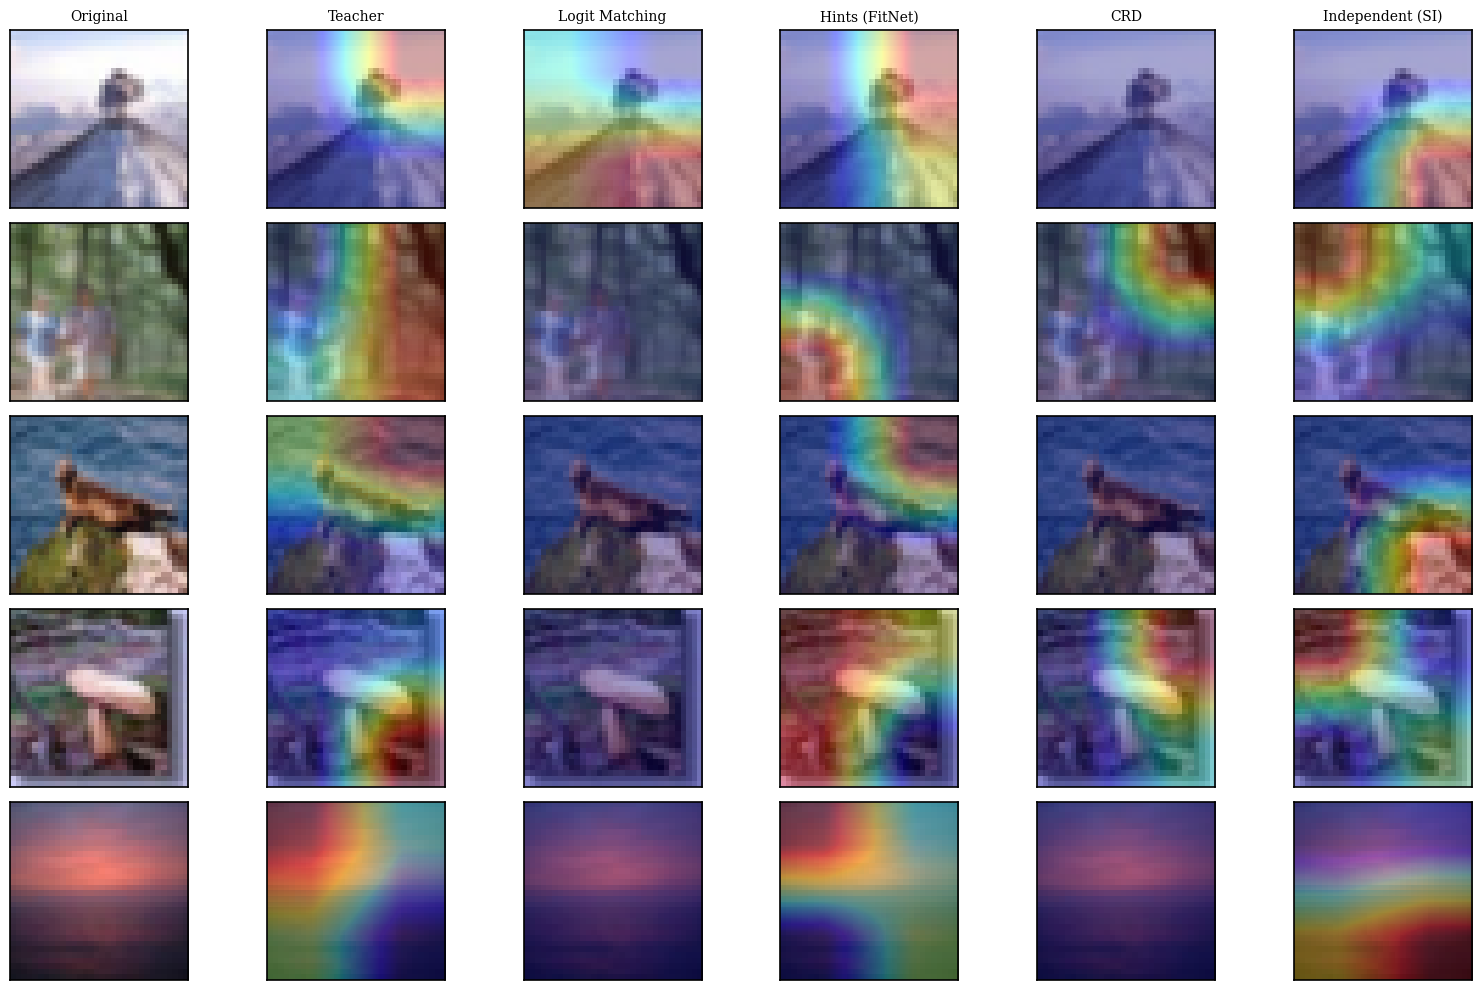


=== CAM Similarity to Teacher (mean over the 5 images) ===
Model               | Cosine  | IoU@20%
--------------------+---------+--------
Logit Matching       |  0.0421 | 0.1637
Hints (FitNet)       |  0.6759 | 0.4436
CRD                  |  0.2917 | 0.2308
Independent (SI)     |  0.3930 | 0.0000


In [ ]:
models_for_grid = OrderedDict([
    ("Teacher", teacher),
    ("Logit Matching", student_logit),
    ("Hints (FitNet)", trained_fit),
    ("CRD", trained_crd),
    ("Independent (SI)", independent_student),
])

draw_gradcam_grid(models_for_grid, test_loader, device=device, n_rows=5, figsize=(16,10))

##Checking for Color Invariance with CRD

In [ ]:
# Strong-ish color jitter
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)

train_transform_jitter = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=1.0),  # always jitter for FT
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

test_transform_jitter = transforms.Compose([
    transforms.RandomApply([color_jitter], p=1.0),  # jittered eval set
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

data_root = "./data"
batch_size = 128

train_set_jitter = datasets.CIFAR100(root=data_root, train=True,  download=True, transform=train_transform_jitter)
test_set_jitter  = datasets.CIFAR100(root=data_root, train=False, download=True, transform=test_transform_jitter)

train_loader_jitter = DataLoader(train_set_jitter, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_loader_jitter  = DataLoader(test_set_jitter,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"[Jitter] Train: {len(train_set_jitter)}  Test: {len(test_set_jitter)}")

[Jitter] Train: 50000  Test: 10000


In [ ]:
def finetune_with_jitter(model, train_loader, val_loader, epochs=15,
                         base_lr=0.005, head_lr_mult=5.0, momentum=0.9, weight_decay=5e-4, device="cuda"):
    """
    Finetunes a pretrained model with color jitter data.
    Param groups: classifier gets higher LR than features.
    """
    model = model.to(device)
    model.train()

    # Split param groups (VGG-style models have features + classifier)
    features_params   = []
    classifier_params = []
    for name, p in model.named_parameters():
        if not p.requires_grad: continue
        (classifier_params if "classifier" in name else features_params).append(p)

    optimizer = optim.SGD(
        [{"params": features_params, "lr": base_lr},
         {"params": classifier_params, "lr": base_lr * head_lr_mult}],
        momentum=momentum, weight_decay=weight_decay
    )
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        t0 = time.time()
        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # eval on jittered val/test
        model.eval()
        _, val_acc = evaluate(model, val_loader, device=device)

        print(f"[FT-Jitter] Ep {epoch:02d}/{epochs} — train_loss {train_loss:.4f} — "
              f"train_acc {train_acc:.2f}% — jit_val_acc {val_acc:.2f}% — {time.time()-t0:.1f}s")
    return model

teacher_color = torch.hub.load("chenyaofo/pytorch-cifar-models", teacher_name, pretrained=True).to(device).eval()

teacher_color = finetune_with_jitter(teacher_color, train_loader_jitter, test_loader_jitter,
                                     epochs=15, base_lr=0.005, head_lr_mult=5.0, device=device)

loss_to, acc_to = evaluate(teacher,  test_loader_jitter, device=device)
print(f"\n[Baseline] Original Teacher on JITTERED test: {acc_to:.2f}%")

loss_tc, acc_tc = evaluate(teacher_color, test_loader_jitter, device=device)
print(f"[After FT] Color-Jitter Teacher on JITTERED test: {acc_tc:.2f}%")

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[FT-Jitter] Ep 01/15 — train_loss 0.5148 — train_acc 87.69% — jit_val_acc 64.07% — 47.3s
[FT-Jitter] Ep 02/15 — train_loss 0.5058 — train_acc 87.72% — jit_val_acc 63.68% — 49.1s
[FT-Jitter] Ep 03/15 — train_loss 0.4663 — train_acc 88.34% — jit_val_acc 64.81% — 48.9s
[FT-Jitter] Ep 04/15 — train_loss 0.4756 — train_acc 88.27% — jit_val_acc 64.83% — 49.0s
[FT-Jitter] Ep 05/15 — train_loss 0.4495 — train_acc 88.97% — jit_val_acc 65.45% — 48.5s
[FT-Jitter] Ep 06/15 — train_loss 0.4345 — train_acc 89.08% — jit_val_acc 65.26% — 47.7s
[FT-Jitter] Ep 07/15 — train_loss 0.4328 — train_acc 89.11% — jit_val_acc 65.52% — 48.6s
[FT-Jitter] Ep 08/15 — train_loss 0.3987 — train_acc 89.99% — jit_val_acc 65.81% — 49.5s
[FT-Jitter] Ep 09/15 — train_loss 0.3973 — train_acc 90.05% — jit_val_acc 65.96% — 49.1s
[FT-Jitter] Ep 10/15 — train_loss 0.3976 — train_acc 89.92% — jit_val_acc 65.51% — 48.0s
[FT-Jitter] Ep 11/15 — train_loss 0.3864 — train_acc 90.25% — jit_val_acc 66.01% — 48.9s
[FT-Jitter] Ep 12/15 

In [ ]:
student_crd_color = get_vgg11_untrained()
trained_crd_color, crd_color_train_accs, crd_color_test_accs  = train_student_crd(
    student_crd_color, teacher_color,   # distill FROM color-jittered teacher
    train_loader,                       # IMPORTANT: OLD regular train loader (no color jitter)
    test_loader,                        # just for periodic logging
    epochs=50, lr=0.01, momentum=0.9, weight_decay=5e-4,
    alpha_ce=1.0, beta_crd=0.8, tau=0.07, proj_dim=128, device=device
)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[CRD] Epoch 01/50 — train_loss: 7.2843 — train_acc: 2.83% — test_acc: 10.59% — time: 24.5s
[CRD] Epoch 02/50 — train_loss: 5.7901 — train_acc: 14.11% — test_acc: 22.41% — time: 24.8s
[CRD] Epoch 03/50 — train_loss: 4.9529 — train_acc: 23.24% — test_acc: 30.61% — time: 23.9s
[CRD] Epoch 04/50 — train_loss: 4.4237 — train_acc: 29.70% — test_acc: 36.06% — time: 24.3s
[CRD] Epoch 05/50 — train_loss: 4.0226 — train_acc: 34.40% — test_acc: 37.57% — time: 24.6s
[CRD] Epoch 06/50 — train_loss: 3.7024 — train_acc: 38.19% — test_acc: 42.80% — time: 23.6s
[CRD] Epoch 07/50 — train_loss: 3.4408 — train_acc: 41.49% — test_acc: 45.91% — time: 24.2s
[CRD] Epoch 08/50 — train_loss: 3.1982 — train_acc: 44.30% — test_acc: 44.53% — time: 24.8s
[CRD] Epoch 09/50 — train_loss: 3.0252 — train_acc: 46.39% — test_acc: 48.97% — time: 25.1s
[CRD] Epoch 10/50 — train_loss: 2.8358 — train_acc: 49.14% — test_acc: 50.92% — time: 25.2s
[CRD] Epoch 11/50 — train_loss: 2.6824 — train_acc: 50.76% — test_acc: 51.98% — t

In [ ]:
# =========================
# 4) Compare on jittered test set
# =========================
# Old CRD (you trained earlier as `trained_crd`)
loss_old_crd_j, acc_old_crd_j = evaluate(trained_crd,       test_loader_jitter, device=device)
loss_new_crd_j, acc_new_crd_j = evaluate(trained_crd_color, test_loader_jitter, device=device)

print("\n=== Color Invariance Study (Jittered Test) ===")
print(f"Original Teacher          : {acc_to:.2f}%")
print(f"Color-Jitter FT Teacher   : {acc_tc:.2f}%")
print(f"Old CRD Student (old T)   : {acc_old_crd_j:.2f}%")
print(f"NEW CRD Student (color T) : {acc_new_crd_j:.2f}%")


=== Color Invariance Study (Jittered Test) ===
Original Teacher          : 65.69%
Color-Jitter FT Teacher   : 64.92%
Old CRD Student (old T)   : 54.02%
NEW CRD Student (color T) : 55.01%


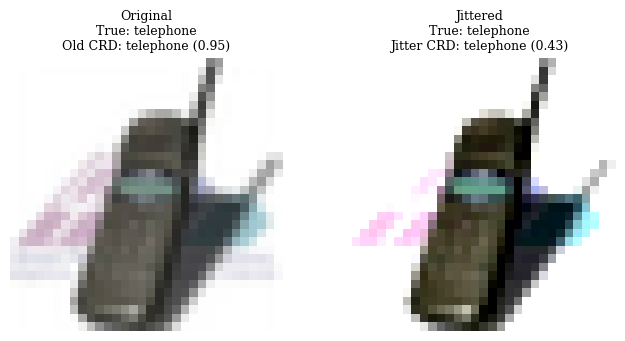

In [ ]:

def _denorm(img_t):
    # img_t: (3,H,W) normalized tensor
    mean = torch.tensor(CIFAR100_MEAN).view(3,1,1)
    std  = torch.tensor(CIFAR100_STD).view(3,1,1)
    x = img_t.cpu() * std + mean
    return x.clamp(0,1)

@torch.no_grad()
def show_random_original_and_jitter_prediction(
        test_set, test_set_jitter, trained_crd, trained_crd_color, device="cuda"):
    # pick one random index
    idx = torch.randint(len(test_set), (1,)).item()

    # fetch normalized tensors
    img_norm, y = test_set[idx]              # normalized tensor (3,32,32)
    img_jit_norm, _ = test_set_jitter[idx]   # normalized tensor (3,32,32)

    # for display
    img_disp = _denorm(img_norm)
    img_jit_disp = _denorm(img_jit_norm)

    # for prediction
    x = img_norm.unsqueeze(0).to(device)
    xj = img_jit_norm.unsqueeze(0).to(device)

    trained_crd.eval()
    trained_crd_color.eval()

    # preds + probs
    logits_old = trained_crd(x)
    logits_new = trained_crd_color(xj)

    prob_old = torch.softmax(logits_old, dim=1)[0]
    prob_new = torch.softmax(logits_new, dim=1)[0]

    pred_old = prob_old.argmax().item()
    pred_new = prob_new.argmax().item()

    cls_names = test_set.classes if hasattr(test_set, "classes") else [str(i) for i in range(100)]
    true_name = cls_names[y]
    old_name  = cls_names[pred_old]
    new_name  = cls_names[pred_new]

    p_old = prob_old[pred_old].item()
    p_new = prob_new[pred_new].item()

    # plot
    plt.figure(figsize=(6.8, 3.4))
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(np.transpose(img_disp.numpy(), (1,2,0)))
    ax1.set_title(f"Original\nTrue: {true_name}\nOld CRD: {old_name} ({p_old:.2f})", fontsize=9)
    ax1.axis('off')

    ax2 = plt.subplot(1,2,2)
    ax2.imshow(np.transpose(img_jit_disp.numpy(), (1,2,0)))
    ax2.set_title(f"Jittered\nTrue: {true_name}\nJitter CRD: {new_name} ({p_new:.2f})", fontsize=9)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# call it
show_random_original_and_jitter_prediction(
    test_set, test_set_jitter, trained_crd, trained_crd_color, device=device
)

##Testing the Efficacy of a Larger Teacher

In [7]:
teacher19_name = "cifar100_vgg19_bn"
teacher_vgg19 = torch.hub.load("chenyaofo/pytorch-cifar-models", teacher19_name, pretrained=True).to(device).eval()

print("Loaded pretrained teacher:", teacher19_name)
t19_loss, t19_acc = evaluate(teacher_vgg19, test_loader, device=device)
print(f"Teacher ({teacher19_name}) test — loss: {t19_loss:.4f}, acc: {t19_acc:.2f}%")

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg19_bn-b98f7bd7.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg19_bn-b98f7bd7.pt


100%|██████████| 78.7M/78.7M [00:01<00:00, 43.6MB/s]


Loaded pretrained teacher: cifar100_vgg19_bn
Teacher (cifar100_vgg19_bn) test — loss: 1.8049, acc: 73.85%


In [8]:
# -------- Logit-Matching student distilled from VGG-19 --------
# reuses your get_vgg11_untrained() and train_logit_matching(...)
student_logit_vgg19 = get_vgg11_untrained()
print("Training Logit Matching student (teacher = VGG-19)...")
trained_logit_vgg19, lm19_train_accs, lm19_test_accs = train_logit_matching(
    student_logit_vgg19, teacher_vgg19,
    train_loader, test_loader,
    epochs=50, lr=0.01, alpha=0.5, T=4.0, device=device
)

Training Logit Matching student (teacher = VGG-19)...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


[LogitMatch] Epoch 01/50 — loss: 13.4067 — train_acc: 1.82% — test_acc: 3.52% — time: 25.2s
[LogitMatch] Epoch 02/50 — loss: 12.0483 — train_acc: 6.57% — test_acc: 10.24% — time: 25.3s
[LogitMatch] Epoch 03/50 — loss: 10.9523 — train_acc: 11.81% — test_acc: 16.28% — time: 25.1s
[LogitMatch] Epoch 04/50 — loss: 10.1110 — train_acc: 17.27% — test_acc: 19.94% — time: 24.9s
[LogitMatch] Epoch 05/50 — loss: 9.3870 — train_acc: 22.72% — test_acc: 26.25% — time: 24.9s
[LogitMatch] Epoch 06/50 — loss: 8.7943 — train_acc: 27.72% — test_acc: 32.11% — time: 25.1s
[LogitMatch] Epoch 07/50 — loss: 8.2744 — train_acc: 32.15% — test_acc: 37.03% — time: 25.0s
[LogitMatch] Epoch 08/50 — loss: 7.8584 — train_acc: 35.81% — test_acc: 37.15% — time: 25.1s
[LogitMatch] Epoch 09/50 — loss: 7.4542 — train_acc: 38.77% — test_acc: 42.39% — time: 25.1s
[LogitMatch] Epoch 10/50 — loss: 7.1425 — train_acc: 41.84% — test_acc: 45.99% — time: 25.1s
[LogitMatch] Epoch 11/50 — loss: 6.8470 — train_acc: 44.59% — test_ac

In [9]:
# -------- Final comparison: LM@VGG-16 (old) vs LM@VGG-19 (new) --------
# assumes you already have `trained_logit` from your VGG-16 LM run
#loss_logit16, acc_logit16 = evaluate(trained_logit,        test_loader, device=device)
loss_logit19, acc_logit19 = evaluate(trained_logit_vgg19,  test_loader, device=device)

#print("\n=== LM Student Comparison (same hyperparams, same data) ===")
#print(f"LM Student (Teacher VGG-16): {acc_logit16:.2f}%")
print(f"LM Student (Teacher VGG-19): {acc_logit19:.2f}%")

LM Student (Teacher VGG-19): 61.64%


In [ ]:
# from google.colab import runtime
# runtime.unassign()